Import Modul

In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Diubah dari RandomForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [44]:
try:
    df = pd.read_csv('smmh.csv')
    # Membersihkan nama kolom dari angka di depan dan tanda tanya di belakang
    df.columns = df.columns.str.replace(r'^\d+\W*\s*|\s*\(\d+-\d+\)$|\?$|^\s*|\s*$', '', regex=True)

    # Buat dictionary rename untuk kolom-kolom lain
    rename_map = {
        'What is your age': 'Age',
        'Gender': 'Gender',
        'Relationship Status': 'Relationship_Status',
        'Occupation Status': 'Occupation_Status',
        'Do you use social media': 'Use_Social_Media',
        'What is the average time you spend on social media every day': 'Avg_Time_Social_Media',
        'How often do you find yourself using Social media without a specific purpose': 'SM_No_Purpose',
        'How often do you get distracted by Social media when you are busy doing something': 'SM_Distraction_Busy',
        'On a scale of 1 to 5, how easily distracted are you': 'Easily_Distracted',
        'On a scale of 1 to 5, how much are you bothered by worries': 'Bothered_By_Worries',
        'Do you find it difficult to concentrate on things': 'Difficult_To_Concentrate',
        'On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media': 'SM_Compare_Success',
        'Following the previous question, how do you feel about these comparisons, generally speaking': 'SM_Compare_Feeling',
        'How often do you look to seek validation from features of social media': 'SM_Seek_Validation',
        'How often do you feel depressed or down': 'Feel_Depressed',
        'On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate': 'Interest_Fluctuation',
        'On a scale of 1 to 5, how often do you face issues regarding sleep': 'Sleep_Issues'
    }

    for col in df.columns:
        if 'restless if' in col:
            rename_map[col] = 'SM_Restless'
            break # Hentikan loop jika sudah ketemu

    # Lakukan rename pake map yang udah kita buat
    df.rename(columns=rename_map, inplace=True)
    
    print("✅ Dataset berhasil dimuat dan nama kolom disederhanakan.")
    print("\nLima baris pertama data:")
    display(df.head())
    print("\nInformasi Tipe Data:")
    df.info()
except FileNotFoundError:
    print("🚨 ERROR: File 'smmh.csv' tidak ditemukan! Pastikan file ada di folder yang sama.")

✅ Dataset berhasil dimuat dan nama kolom disederhanakan.

Lima baris pertama data:


,Timestamp,Age,Gender,Relationship_Status,Occupation_Status,What type of organizations are you affiliated with,Use_Social_Media,What social media platforms do you commonly use,Avg_Time_Social_Media,SM_No_Purpose,...,SM_Restless,Easily_Distracted,Bothered_By_Worries,Difficult_To_Concentrate,SM_Compare_Success,SM_Compare_Feeling,SM_Seek_Validation,Feel_Depressed,Interest_Fluctuation,Sleep_Issues
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,5,4,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,5,4,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,4,2,5
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,4,3,2
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,4,1



Informasi Tipe Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 21 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Timestamp                                           481 non-null    object 
 1   Age                                                 481 non-null    float64
 2   Gender                                              481 non-null    object 
 3   Relationship_Status                                 481 non-null    object 
 4   Occupation_Status                                   481 non-null    object 
 5   What type of organizations are you affiliated with  451 non-null    object 
 6   Use_Social_Media                                    481 non-null    object 
 7   What social media platforms do you commonly use     481 non-null    object 
 8   Avg_Time_Social_Media                               481 no

Deteksi Missing Value

In [45]:
print("\n--- Menganalisis Missing Values ---")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Jumlah Missing': missing_values, 'Persentase (%)': missing_percentage})
missing_df_filtered = missing_df[missing_df['Jumlah Missing'] > 0].sort_values(by='Jumlah Missing', ascending=False)

if missing_df_filtered.empty:
    print("✅ Tidak ditemukan missing value pada data.")
else:
    print("Ditemukan missing value pada kolom berikut:")
    display(missing_df_filtered)



--- Menganalisis Missing Values ---
Ditemukan missing value pada kolom berikut:


,Jumlah Missing,Persentase (%)
What type of organizations are you affiliated with,30,6.237006


Deteksi Outlier


--- Menganalisis Outlier dengan Box Plot ---


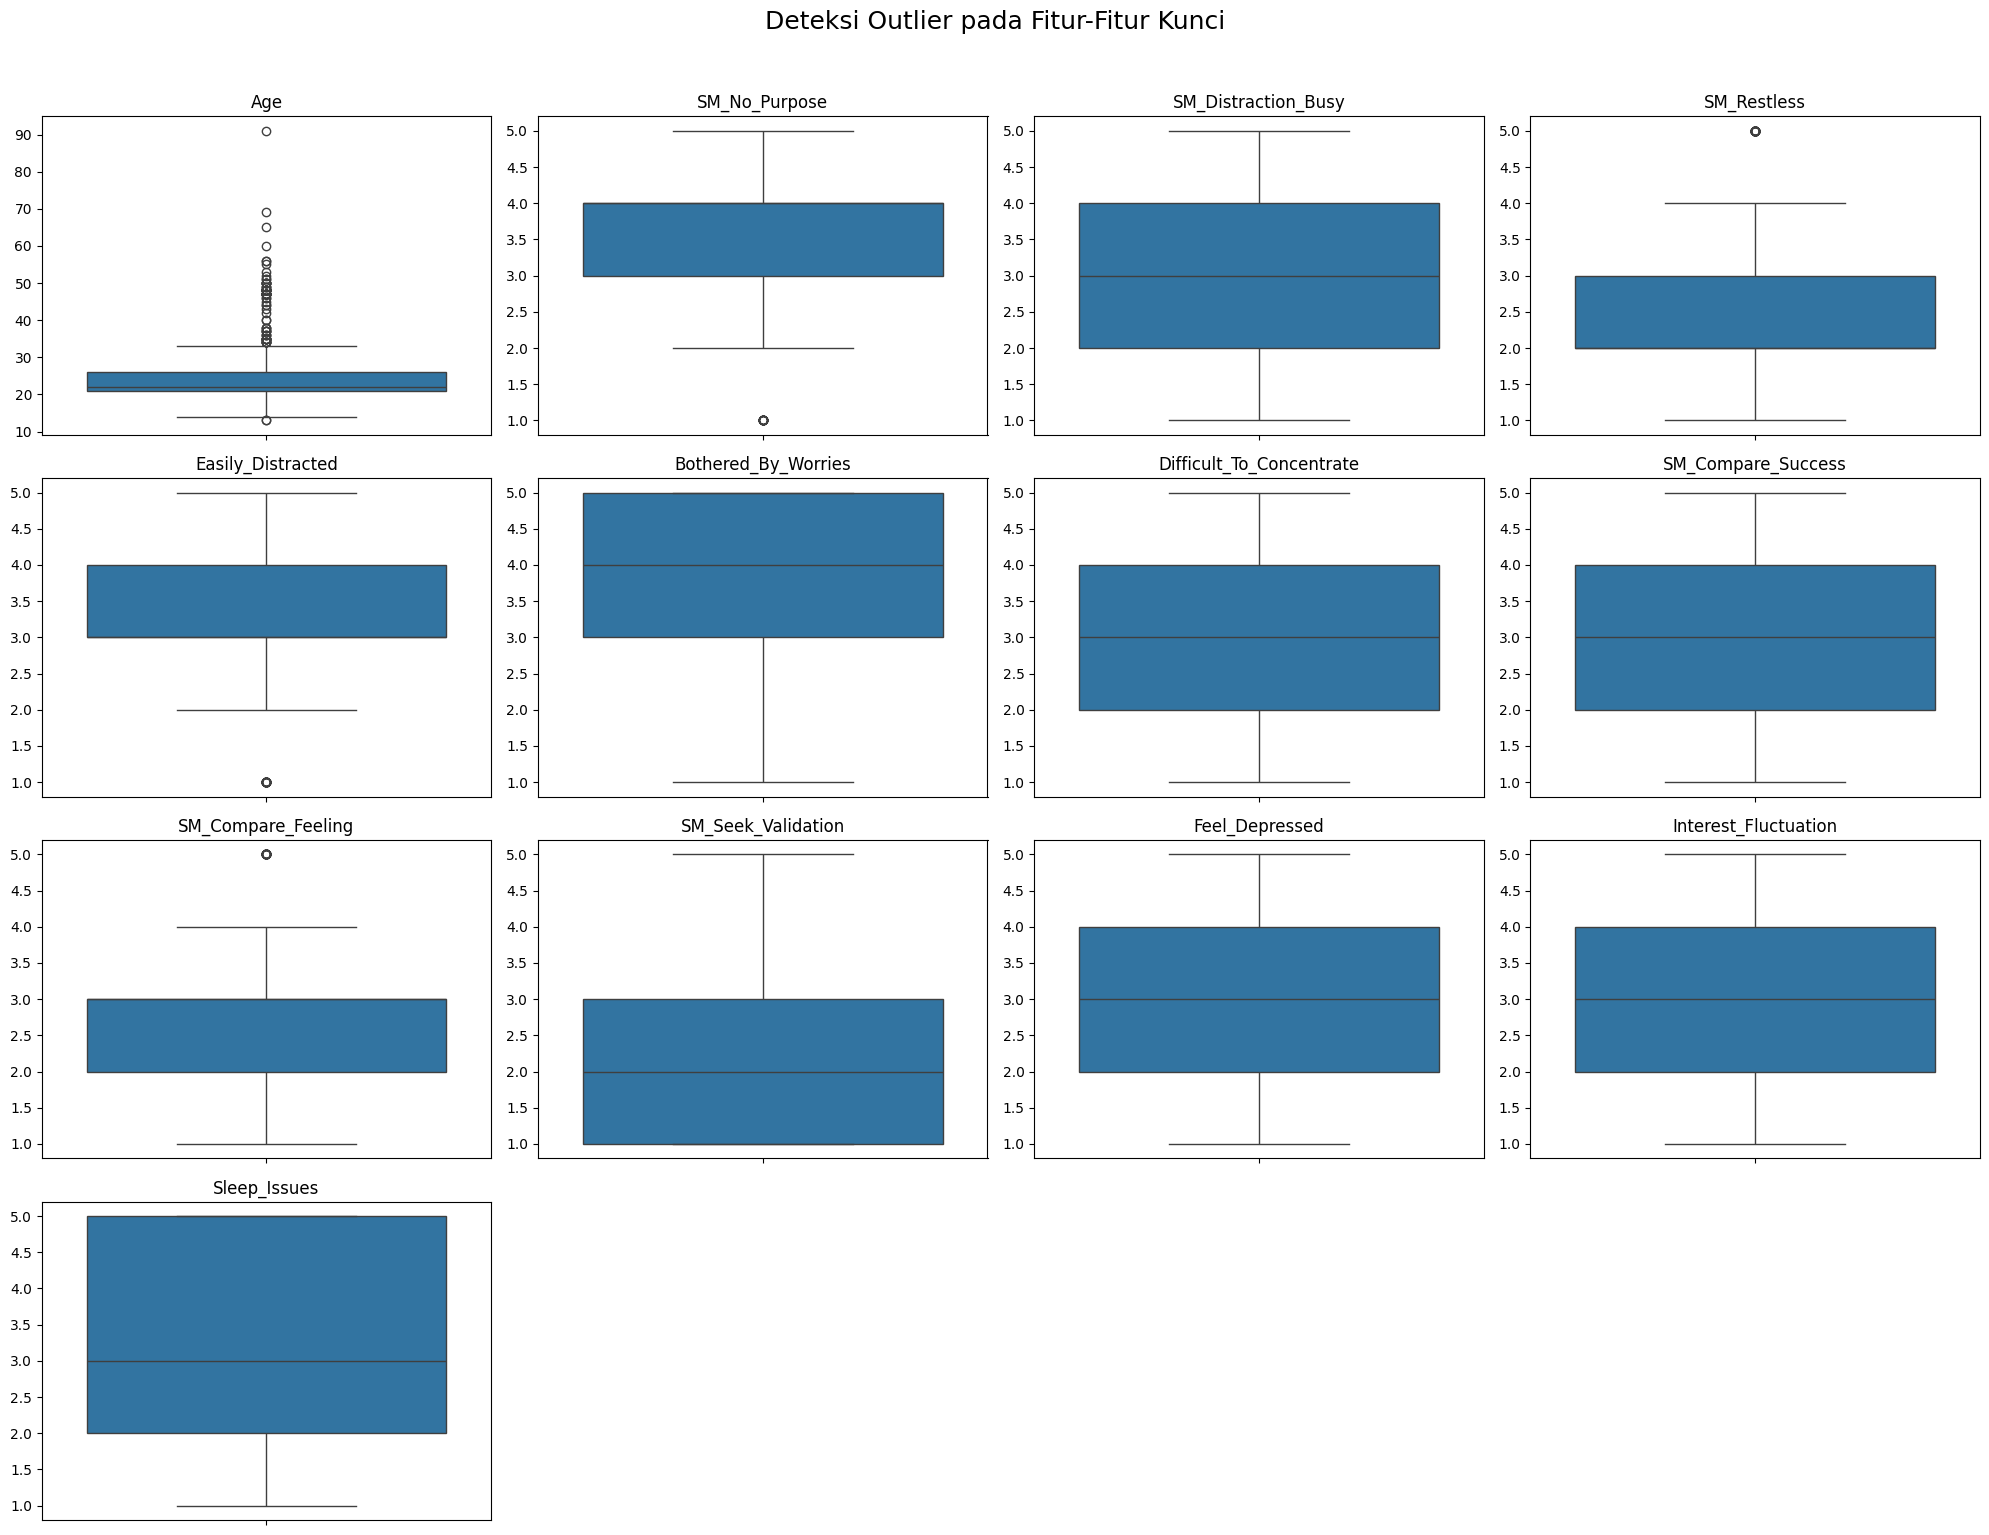

In [46]:
print("\n--- Menganalisis Outlier dengan Box Plot ---")
# Pilih kolom numerik asli untuk deteksi outlier
kolom_numerik_outlier = [
    'Age', 'SM_No_Purpose', 'SM_Distraction_Busy', 'SM_Restless', 'Easily_Distracted',
    'Bothered_By_Worries', 'Difficult_To_Concentrate', 'SM_Compare_Success',
    'SM_Compare_Feeling', 'SM_Seek_Validation', 'Feel_Depressed',
    'Interest_Fluctuation', 'Sleep_Issues'
]

plt.figure(figsize=(20, 15))
plt.suptitle('Deteksi Outlier pada Fitur-Fitur Kunci', fontsize=18, y=1.02)

for i, col in enumerate(kolom_numerik_outlier):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col, fontsize=12)
    plt.ylabel('')

plt.tight_layout()
plt.show()



EDA Lanjutan (Visualisasi)

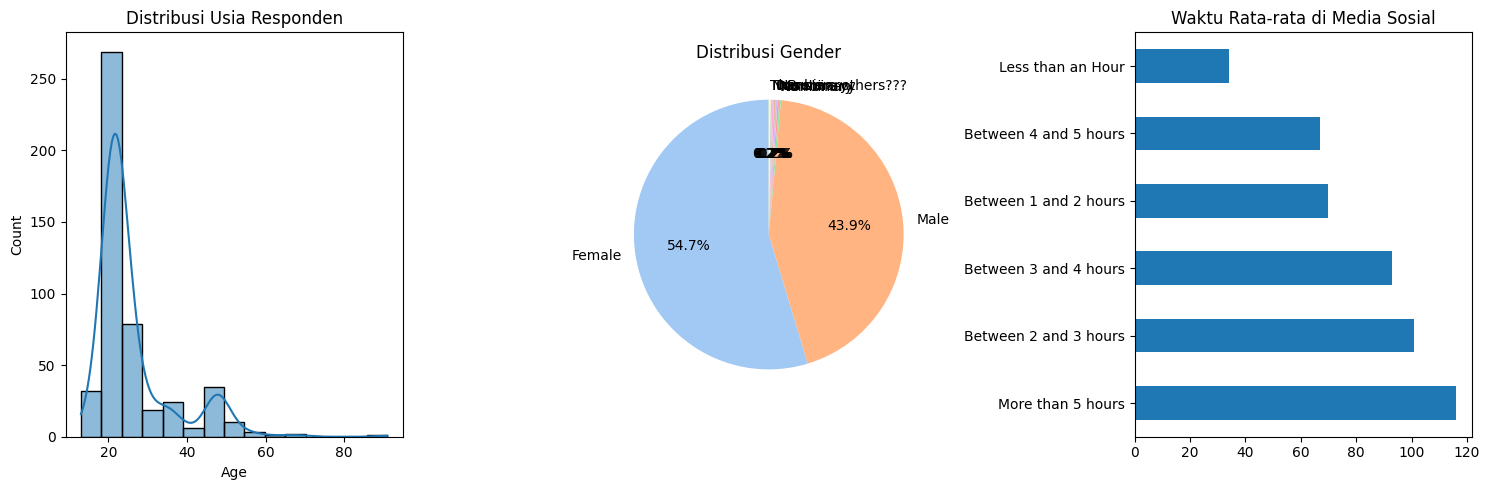

In [47]:
plt.figure(figsize=(15, 5))

# Plot 1: Distribusi Usia
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=15)
plt.title('Distribusi Usia Responden')

# Plot 2: Distribusi Gender
plt.subplot(1, 3, 2)
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribusi Gender')
plt.ylabel('') # Hapus label y-axis yang tidak perlu

# Plot 3: Waktu Rata-rata di Media Sosial
plt.subplot(1, 3, 3)
df['Avg_Time_Social_Media'].value_counts().plot(kind='barh')
plt.title('Waktu Rata-rata di Media Sosial')

plt.tight_layout()
plt.show()


Preprocessing untuk K-Means

In [48]:
df['KMeans_Gangguan_Konsentrasi'] = df[['SM_Distraction_Busy', 'Easily_Distracted', 'Difficult_To_Concentrate']].mean(axis=1)
df['KMeans_Pencarian_Validasi'] = df[['SM_Seek_Validation', 'SM_Compare_Success']].mean(axis=1)

# Kolom untuk K-Means
kolom_kmeans_numerik = ['SM_No_Purpose', 'KMeans_Gangguan_Konsentrasi', 'KMeans_Pencarian_Validasi', 'Bothered_By_Worries']
kolom_kmeans_kategori_ordinal = ['Avg_Time_Social_Media']

df_kmeans_selection = df[kolom_kmeans_numerik + kolom_kmeans_kategori_ordinal].copy()

# Ordinal Encoding untuk 'Avg_Time_Social_Media'
# Perbaikan urutan kategori berdasarkan observasi umum pada dataset
time_categories_corrected = [
    'Less than an Hour', 'Between 1 and 2 hours', 'Between 2 and 3 hours', 
    'Between 3 and 4 hours', 'Between 4 and 5 hours', 'More than 5 hours'
]
# Pastikan nama-nama kategori di time_categories_corrected sesuai dengan nilai unik di kolom 'Avg_Time_Social_Media'
ordinal_encoder_time = OrdinalEncoder(categories=[time_categories_corrected], handle_unknown='use_encoded_value', unknown_value=np.nan)

df_kmeans_selection['Avg_Time_Social_Media_Encoded'] = ordinal_encoder_time.fit_transform(df_kmeans_selection[['Avg_Time_Social_Media']])
df_kmeans_processed = df_kmeans_selection.drop(columns=['Avg_Time_Social_Media'])
kolom_kmeans_final = ['Avg_Time_Social_Media_Encoded'] + kolom_kmeans_numerik

# Isi missing values (jika ada setelah encoding atau dari rata-rata)
for col in kolom_kmeans_final:
    if df_kmeans_processed[col].isnull().any():
        df_kmeans_processed[col] = df_kmeans_processed[col].fillna(df_kmeans_processed[col].median())
        print(f"Missing values di '{col}' (K-Means) diisi dengan median.")

# Scaling untuk K-Means
scaler_kmeans = StandardScaler()
kmeans_scaled = scaler_kmeans.fit_transform(df_kmeans_processed[kolom_kmeans_final])
print("\nData K-Means setelah preprocessing dan scaling (5 baris pertama):\n", pd.DataFrame(kmeans_scaled, columns=kolom_kmeans_final).head())




Data K-Means setelah preprocessing dan scaling (5 baris pertama):
    Avg_Time_Social_Media_Encoded  SM_No_Purpose  KMeans_Gangguan_Konsentrasi  \
0                      -0.571879       1.321256                     0.937843   
1                       1.316499       0.408147                     0.329888   
2                       0.057580      -0.504963                    -0.582044   
3                       1.316499       0.408147                    -0.582044   
4                      -0.571879      -0.504963                     1.241820   

   KMeans_Pencarian_Validasi  Bothered_By_Worries  
0                  -0.575831            -1.216245  
1                   0.319079             1.123810  
2                  -0.575831             1.123810  
3                   0.766534             1.123810  
4                   0.319079             1.123810  


K-Means Clustering


--- Menentukan K Optimal dengan Elbow Method ---


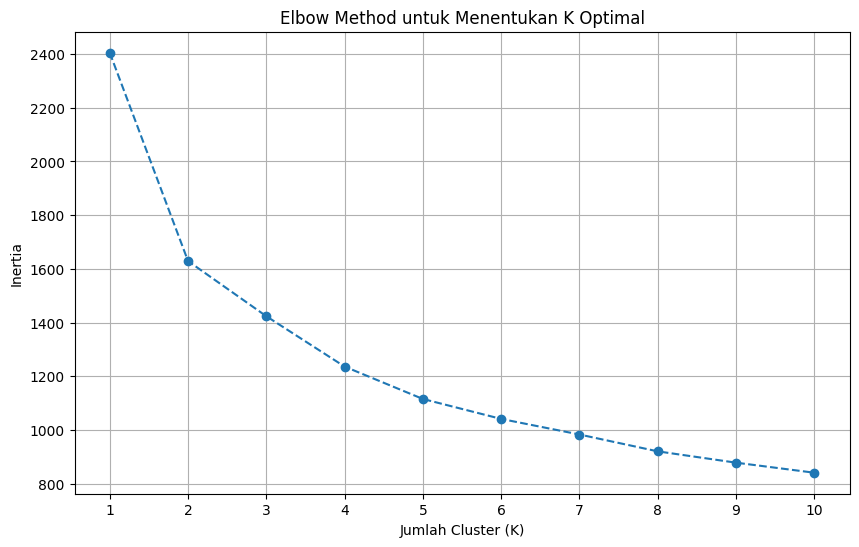


--- Menjalankan Clustering dengan K=4 ---

Hasil clustering K-Means (K=4), 5 baris pertama dengan label cluster (data sebelum scaling):
   SM_No_Purpose  KMeans_Gangguan_Konsentrasi  KMeans_Pencarian_Validasi  \
0              5                     4.333333                        2.0   
1              4                     3.666667                        3.0   
2              3                     2.666667                        2.0   
3              4                     2.666667                        3.5   
4              3                     4.666667                        3.0   

   Bothered_By_Worries  Avg_Time_Social_Media_Encoded  Cluster_KMeans  
0                    2                            2.0               1  
1                    5                            5.0               2  
2                    5                            3.0               0  
3                    5                            5.0               2  
4                    5                        

In [50]:
print("\n--- Menentukan K Optimal dengan Elbow Method ---")
inertia = []
K_range = range(1, 11)
for k_val in K_range:
    kmeans_model = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans_model.fit(kmeans_scaled)
    inertia.append(kmeans_model.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Berdasarkan plot, K=4 tampak sebagai "siku" yang baik.
k_optimal = 4
print(f"\n--- Menjalankan Clustering dengan K={k_optimal} ---")

final_kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
# Tambahkan label cluster ke DataFrame utama
df['Cluster_KMeans'] = final_kmeans.fit_predict(kmeans_scaled)

# Untuk menampilkan hasil, kita gabungkan kolom-kolom yang dipakai K-Means dengan label clusternya
df_kmeans_final_interpret = df_kmeans_processed.copy()
df_kmeans_final_interpret['Cluster_KMeans'] = df['Cluster_KMeans']

print(f"\nHasil clustering K-Means (K={k_optimal}), 5 baris pertama dengan label cluster (data sebelum scaling):")
print(df_kmeans_final_interpret.head())

print("\nKarakteristik rata-rata per cluster (fitur yang sudah di-scale):")
# Buat dataframe dari kmeans_scaled untuk groupby yang benar
df_scaled_with_clusters = pd.DataFrame(kmeans_scaled, columns=kolom_kmeans_final)
df_scaled_with_clusters['Cluster_KMeans'] = df['Cluster_KMeans']
print(df_scaled_with_clusters.groupby('Cluster_KMeans').mean())


Persiapan Supervised Learning (Logistic Regression)

In [51]:
fitur_rf_numerik = ['Age', 'SM_No_Purpose']
fitur_rf_kategori_nominal = ['Gender', 'Relationship_Status']
fitur_rf_kategori_ordinal = ['Avg_Time_Social_Media']

# Preprocessor untuk Logistic Regression
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[time_categories_corrected], handle_unknown='use_encoded_value', unknown_value=-1), fitur_rf_kategori_ordinal),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), fitur_rf_kategori_nominal),
        ('num', StandardScaler(), fitur_rf_numerik)
    ], 
    remainder='passthrough'
)

# Binarisasi Target (skor >= 4 dianggap "Ya" (1), selain itu "Tidak" (0))
threshold = 4 
df['Target_Depresi'] = df['Feel_Depressed'].apply(lambda x: 1 if x >= threshold else 0)
df['Target_Gangguan_Tidur'] = df['Sleep_Issues'].apply(lambda x: 1 if x >= threshold else 0)

print(f"\nDistribusi target Depresi (1 = Ya >= {threshold}, 0 = Tidak < {threshold}):")
print(df['Target_Depresi'].value_counts(normalize=True))
print(f"Distribusi target Gangguan Tidur (1 = Ya >= {threshold}, 0 = Tidak < {threshold}):")
print(df['Target_Gangguan_Tidur'].value_counts(normalize=True))

kolom_fitur_rf_gabungan = fitur_rf_numerik + fitur_rf_kategori_nominal + fitur_rf_kategori_ordinal
X = df[kolom_fitur_rf_gabungan]


Distribusi target Depresi (1 = Ya >= 4, 0 = Tidak < 4):
0    0.540541
1    0.459459
Name: Target_Depresi, dtype: float64
Distribusi target Gangguan Tidur (1 = Ya >= 4, 0 = Tidak < 4):
0    0.511435
1    0.488565
Name: Target_Gangguan_Tidur, dtype: float64


Model Prediksi Depresi (Logistic Regression)


--- Membangun Model Prediksi Depresi ---
Melatih model prediksi depresi...

Hasil Evaluasi Model Prediksi Depresi:
Akurasi: 0.6198
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.69      0.52      0.60        65
           1       0.57      0.73      0.64        56

    accuracy                           0.62       121
   macro avg       0.63      0.63      0.62       121
weighted avg       0.64      0.62      0.62       121

Confusion Matrix:


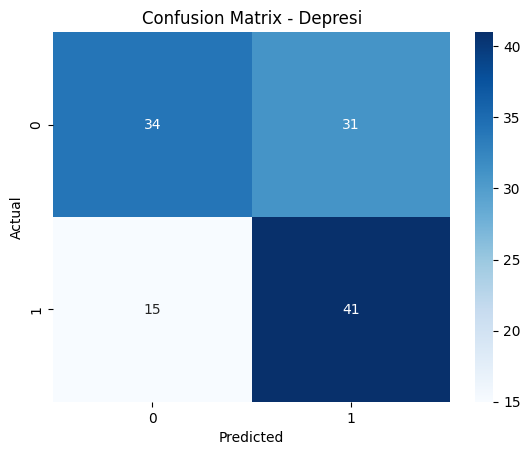

In [52]:
print(f"\n--- Membangun Model Prediksi Depresi ---")
y_depresi = df['Target_Depresi']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_depresi, test_size=0.25, random_state=42, stratify=y_depresi)
model_depresi_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                                         ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))])

print("Melatih model prediksi depresi...")
model_depresi_pipeline.fit(X_train_d, y_train_d)
y_pred_d = model_depresi_pipeline.predict(X_test_d)

print("\nHasil Evaluasi Model Prediksi Depresi:")
print(f"Akurasi: {accuracy_score(y_test_d, y_pred_d):.4f}")
print("Laporan Klasifikasi:\n", classification_report(y_test_d, y_pred_d, zero_division=0))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test_d, y_pred_d), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Depresi')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model Prediksi Gangguan Tidur (Logistic Regression)


--- Membangun Model Prediksi Gangguan Tidur ---
Melatih model prediksi gangguan tidur...

Hasil Evaluasi Model Prediksi Gangguan Tidur:
Akurasi: 0.5207
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.55      0.39      0.45        62
           1       0.51      0.66      0.57        59

    accuracy                           0.52       121
   macro avg       0.53      0.52      0.51       121
weighted avg       0.53      0.52      0.51       121

Confusion Matrix:


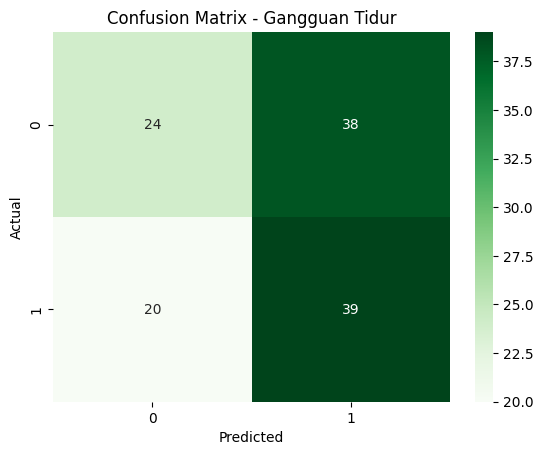

In [53]:
print(f"\n--- Membangun Model Prediksi Gangguan Tidur ---")
y_tidur = df['Target_Gangguan_Tidur']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_tidur, test_size=0.25, random_state=42, stratify=y_tidur)

model_tidur_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                                       ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))])

print("Melatih model prediksi gangguan tidur...")
model_tidur_pipeline.fit(X_train_t, y_train_t)
y_pred_t = model_tidur_pipeline.predict(X_test_t)

print("\nHasil Evaluasi Model Prediksi Gangguan Tidur:")
print(f"Akurasi: {accuracy_score(y_test_t, y_pred_t):.4f}")
print("Laporan Klasifikasi:\n", classification_report(y_test_t, y_pred_t, zero_division=0))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test_t, y_pred_t), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Gangguan Tidur')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()